# Quick Reproduction Code

The ideia of this notebook is to reproduce some of the results stated in [this article](https://arxiv.org/pdf/1901.10159.pdf). There are a series of shortcuts here:

- I don't evaluate the spectrum of the entire CIFAR-10 dataset, but only the spectrum of a random batch. It is much faster do to this and the results should not be very different from those reported in the article. 
- This version is not distributed. It is easy to make a distributed version using the `torch.distributed` module. The idea is to distribute Hessian-vector products of the Lanczos algorithm, the implementation details are explained in the appendix C. 

In [1]:
import torch
import torchvision

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.optim as optim

from torchessian import gauss_quadrature, F
import torchessian.complete
from torchvision.models.resnet import conv3x3, resnet18, ResNet

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 512

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=False, num_workers=2)

# DEBUGING
testset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

m = 90
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def train(net, optimizer, scheduler, criterion, L, W, epochs=15):
    global trainloader
    for epoch in range(epochs):  # loop over the dataset multiple times    

        running_loss = 0.0
#         for i, data in enumerate(trainloader, 0):
        for i, data in enumerate(testloader, 0):# DEBUGING
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            if torch.cuda.is_available():
                inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

        scheduler.step()
            
        if (epoch + 1) % 5 and epoch > 0:
            continue
            
        print('[%d] loss: %.3f' %
              (epoch + 1, running_loss / i))

        running_loss = 0.0
        
#         l, w = gauss_quadrature(net, criterion, (inputs, labels), m, buffer=m)
#         L.append(l)
#         W.append(w)
        
        if epoch < 29:
            continue
            
        l, w = torchessian.complete.gauss_quadrature(net, criterion, testloader, m, buffer=m)
        L.append(l)
        W.append(w)
        


def test(net):
    global testloader
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            if torch.cuda.is_available():
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [4]:
net = resnet18(pretrained=False)
net.fc = torch.nn.Linear(512, 10)
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [5]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9, weight_decay=0.001)
milestones = [15, 20, 25] # To reproduce the results in the article, this should be [100, 150, 200]
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, 0.1)
L, W = [], []
train(net, optimizer, scheduler, criterion, L, W, 30)
test(net) # might achieve a bad generalization score, but this is not the point here

[1] loss: 2.368
[5] loss: 1.333
[10] loss: 0.663
[15] loss: 0.168
[20] loss: 0.062
[25] loss: 0.058
[30] loss: 0.058
[LANCZOS iter 0] batch
[LANCZOS iter 1] batch
[LANCZOS iter 2] batch
[LANCZOS iter 3] batch
[LANCZOS iter 4] batch
[LANCZOS iter 5] batch
[LANCZOS iter 6] batch
[LANCZOS iter 7] batch
[LANCZOS iter 8] batch
[LANCZOS iter 9] batch
[LANCZOS iter 10] batch
[LANCZOS iter 11] batch
[LANCZOS iter 12] batch
[LANCZOS iter 13] batch
[LANCZOS iter 14] batch
[LANCZOS iter 15] batch
[LANCZOS iter 16] batch
[LANCZOS iter 17] batch
[LANCZOS iter 18] batch
[LANCZOS iter 19] batch
[LANCZOS iter 20] batch
[LANCZOS iter 21] batch
[LANCZOS iter 22] batch
[LANCZOS iter 23] batch
[LANCZOS iter 24] batch
[LANCZOS iter 25] batch
[LANCZOS iter 26] batch
[LANCZOS iter 27] batch
[LANCZOS iter 28] batch
[LANCZOS iter 29] batch
[LANCZOS iter 30] batch
[LANCZOS iter 31] batch
[LANCZOS iter 32] batch
[LANCZOS iter 33] batch
[LANCZOS iter 34] batch
[LANCZOS iter 35] batch
[LANCZOS iter 36] batch
[LANC

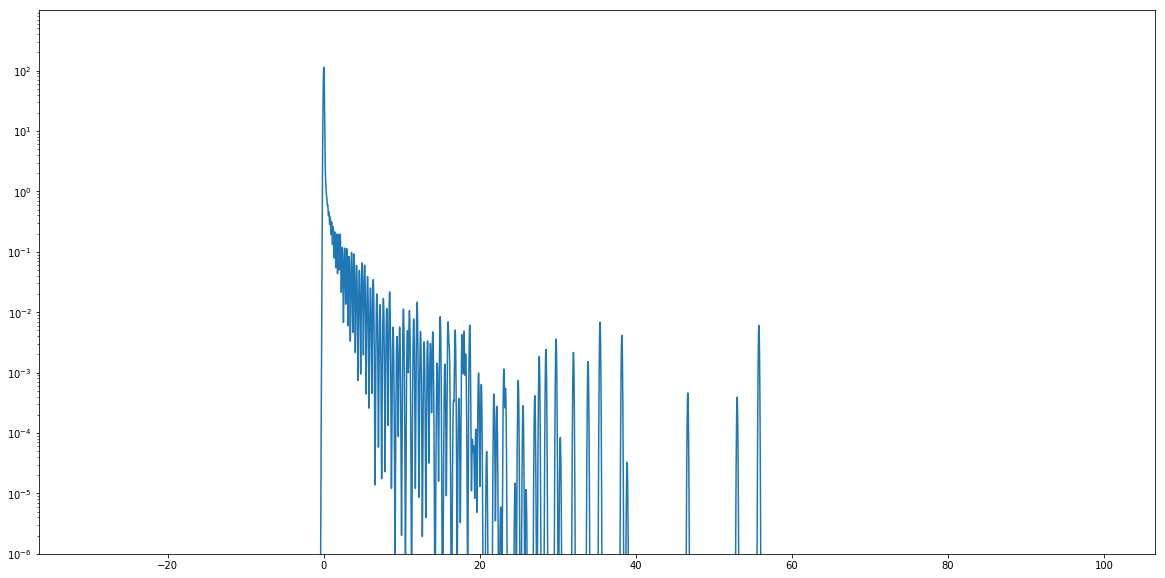

In [12]:
support = torch.linspace(-30, 100, 10000)
density = F(support, L[-1], W[-1], m)
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(support.numpy(), density.numpy())
ax.set_yscale('log')
ax.set_yticks([10 ** (i - 7) for i in range(10)])
ax.set_ylim(10 ** -6, 10 ** 3)
plt.show()

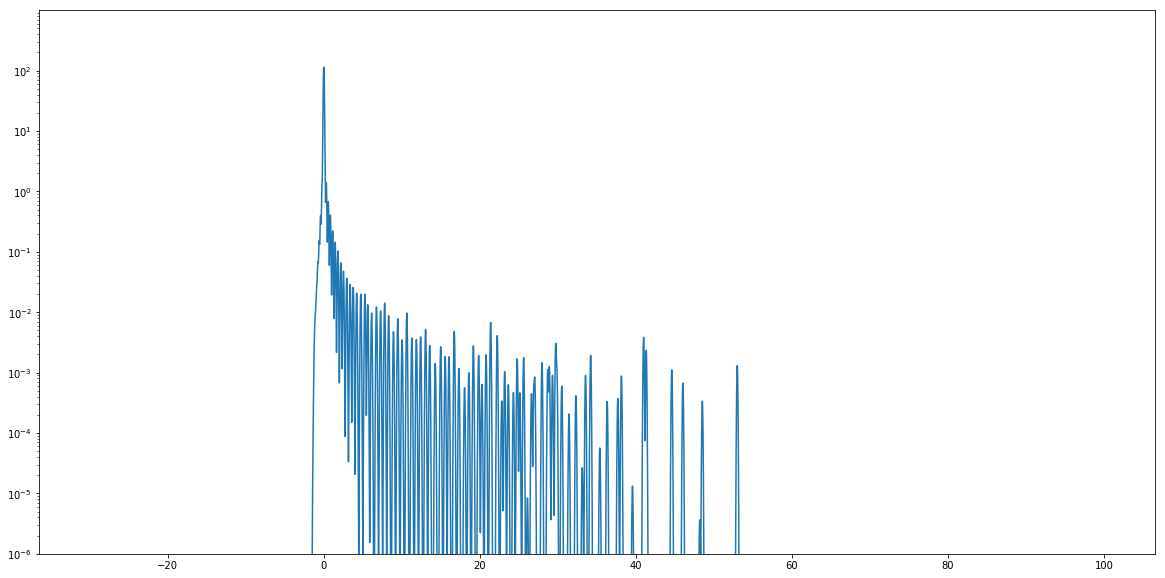

In [19]:
support = torch.linspace(-30, 100, 10000)
density = F(support, L[-1], W[-1], m)
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(support.numpy(), density.numpy())
ax.set_yscale('log')
ax.set_yticks([10 ** (i - 7) for i in range(10)])
ax.set_ylim(10 ** -6, 10 ** 3)
plt.show()

In [10]:
for x in L[-1]:
    print(x)

tensor(55.7551)
tensor(52.9685)
tensor(46.6443)
tensor(38.8678)
tensor(38.1932)
tensor(35.3996)
tensor(33.8630)
tensor(31.9916)
tensor(30.3041)
tensor(29.7690)
tensor(28.4645)
tensor(27.6043)
tensor(27.0402)
tensor(25.9204)
tensor(25.5316)
tensor(24.9152)
tensor(24.5127)
tensor(23.2888)
tensor(23.0749)
tensor(22.6640)
tensor(22.1750)
tensor(21.8064)
tensor(20.8694)
tensor(19.8352)
tensor(20.1855)
tensor(20.2679)
tensor(19.4821)
tensor(19.2039)
tensor(18.7003)
tensor(18.1843)
tensor(17.9636)
tensor(19.0425)
tensor(17.7231)
tensor(17.3121)
tensor(16.6283)
tensor(16.0743)
tensor(15.9232)
tensor(14.9213)
tensor(14.5275)
tensor(13.9702)
tensor(13.6686)
tensor(11.9595)
tensor(11.5221)
tensor(-0.1622)
tensor(-0.1327)
tensor(6.3394)
tensor(5.9859)
tensor(6.7989)
tensor(-0.0849)
tensor(-0.0243)
tensor(0.0016)
tensor(10.9771)
tensor(5.6103)
tensor(7.2018)
tensor(0.0641)
tensor(10.7156)
tensor(7.6386)
tensor(4.9122)
tensor(4.5600)
tensor(4.2010)
tensor(0.1517)
tensor(9.3769)
tensor(3.8711)
tensor

In [13]:
class BasicBlockNoBN(torch.nn.Module):
    expansion = 1
    __constants__ = ['downsample']

    def __init__(self, inplanes, planes, stride=1, downsample=None, groups=1,
                 base_width=64, dilation=1, norm_layer=None):
        super(BasicBlockNoBN, self).__init__()
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.relu = torch.nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [14]:
net = ResNet(BasicBlockNoBN, [2, 2, 2, 2])
net.fc = torch.nn.Linear(512, 10)
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlockNoBN(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BasicBlockNoBN(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
  )
  (layer2): Sequential(
    (0): BasicBlockNoBN(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
      (conv2):

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.002, momentum=0.9, weight_decay=0.001)
milestones = [30, 45, 50] # To reproduce the results in the article, this should be [100, 150, 200]
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones, 0.1)
L_no_bn, W_no_bn = [], []
train(net, optimizer, scheduler, criterion, L_no_bn, W_no_bn, 60)
test(net) # might achieve a bad generalization score, but this is not the point here

[1] loss: 2.244
[5] loss: 1.432
[10] loss: 1.119
[15] loss: 0.895
[20] loss: 0.682
[25] loss: 0.526
[30] loss: 0.404
[LANCZOS iter 0] batch
[LANCZOS iter 1] batch
[LANCZOS iter 2] batch
[LANCZOS iter 3] batch
[LANCZOS iter 4] batch
[LANCZOS iter 5] batch
[LANCZOS iter 6] batch
[LANCZOS iter 7] batch
[LANCZOS iter 8] batch
[LANCZOS iter 9] batch
[LANCZOS iter 10] batch
[LANCZOS iter 11] batch
[LANCZOS iter 12] batch
[LANCZOS iter 13] batch
[LANCZOS iter 14] batch
[LANCZOS iter 15] batch
[LANCZOS iter 16] batch
[LANCZOS iter 17] batch
[LANCZOS iter 18] batch
[LANCZOS iter 19] batch
[LANCZOS iter 20] batch
[LANCZOS iter 21] batch
[LANCZOS iter 22] batch
[LANCZOS iter 23] batch
[LANCZOS iter 24] batch
[LANCZOS iter 25] batch
[LANCZOS iter 26] batch
[LANCZOS iter 27] batch
[LANCZOS iter 28] batch
[LANCZOS iter 29] batch
[LANCZOS iter 30] batch
[LANCZOS iter 31] batch
[LANCZOS iter 32] batch
[LANCZOS iter 33] batch
[LANCZOS iter 34] batch
[LANCZOS iter 35] batch
[LANCZOS iter 36] batch
[LANC

Traceback (most recent call last):
  File "/home/wintics/anaconda3/envs/track/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/wintics/anaconda3/envs/track/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/wintics/anaconda3/envs/track/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/wintics/anaconda3/envs/track/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/wintics/anaconda3/envs/track/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/wintics/anaconda3/envs/track/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/wintics/anaconda3/envs/tra

KeyboardInterrupt: 

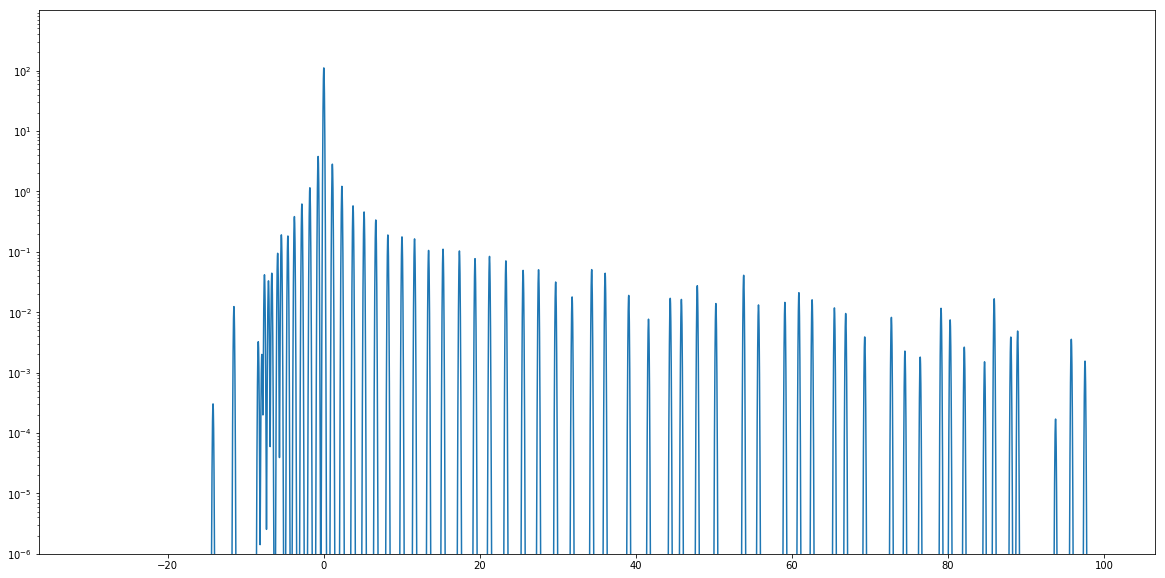

In [17]:
support = torch.linspace(-30, 100, 10000)
density = F(support, L_no_bn[-1], W_no_bn[-1], m)
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(support.numpy(), density.numpy())
ax.set_yscale('log')
ax.set_yticks([10 ** (i - 7) for i in range(10)])
ax.set_ylim(10 ** -6, 10 ** 3)
plt.show()

In [23]:
L_no_bn[-1].max()

tensor(357.5509)

In [25]:
L[-i].max()/L[-i][(L[-i] > 0).nonzero()].min()

tensor(35532.9219)

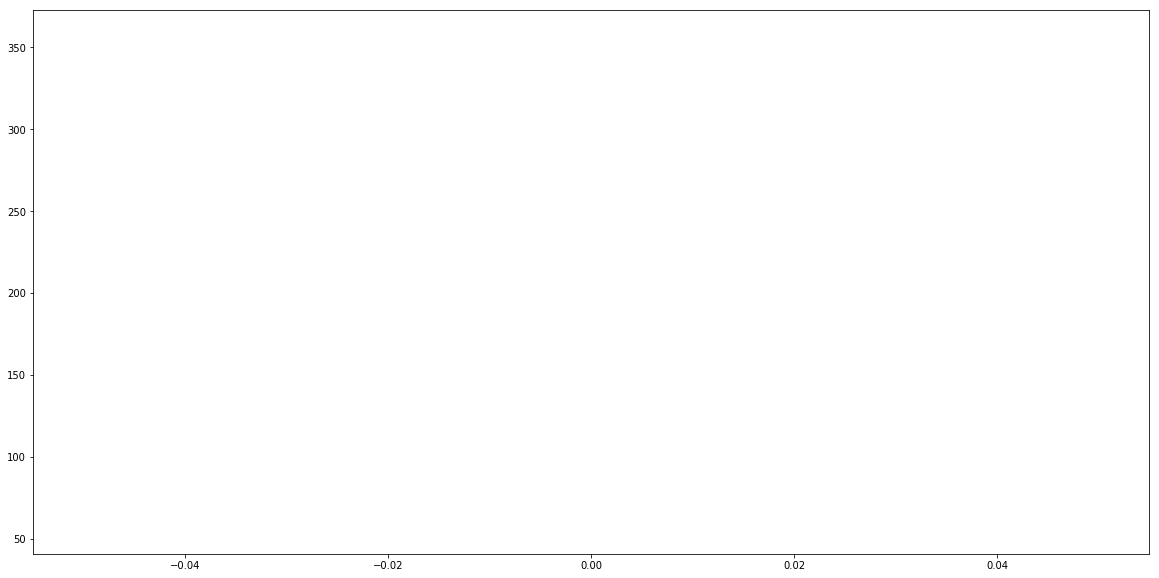

In [19]:
v_bn = []
v_no_bn = []

for i in range(len(L)):
#     eig = L[-i].max()/L[-i][(L[-i] > 0).nonzero()].min()
#     eig_no_bn = L_no_bn[-i].max()/L_no_bn[-i][(L_no_bn[-i] > 0).nonzero()].min()
    eig = L[-i].max()
    eig_no_bn = L_no_bn[-i].max()
    v_bn.append(eig.item())
    v_no_bn.append(eig_no_bn.item())

plt.figure(figsize=(20,10))
plt.plot(v_bn, color='r')
plt.plot(v_no_bn, color='b')
plt.show()